# Superdroplet experiments for Cloudy CES & Comparison
Box model setup with collision coalescence only. Given user-defined initial condition and kernel.

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.physics.formulae import volume

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


## 1. Linear Kernel, gamma distribution

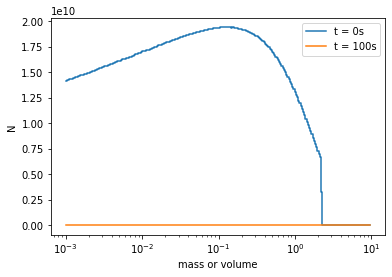

In [5]:
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gamma

n_sd = 2**18
initial_spectrum = Gamma(norm_factor=8.39e12, k=0.0817, theta= 1.5597 * si.um**3)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)
kernel_b = 1/3.14/4 / si.um**3 / si.s

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=0.01 * si.s, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = kernel_b)))
products = [ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np
from scipy import stats

v_bins_edges = np.logspace(np.log10(0.001 * si.um**3), np.log10(10.0 * si.um**3), num=256)

plot_opt = "hist"

for step in [0, 100]:
    particles.run(step - particles.n_steps)
    if (plot_opt == "kde"):
        final_counts = particles.products['N(v)'].get(v_bins_edges)
        n_drop_final = int(particles.products['Mk'].get(0))

        kde_pts = particles.particles.get_extensive_attrs().to_ndarray() / si.um**3
        kde = stats.gaussian_kde(kde_pts[0])

        x = np.linspace(0, 1.0, 100)
        y = kde(x)
        pyplot.plot(x ,y, label=f"t = {step}s")
    elif (plot_opt == "hist"):
        pyplot.xscale('log')
        pyplot.step(x=v_bins_edges[:-1] / si.um**3,
                y=particles.products['N(v)'].get(v_bins_edges),
                where='post', label=f"t = {step}s")
               
pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

## Extract the moments

In [8]:
# Plot the moments over time
from PySDM.products.state import KMoments

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=0.05 * si.s, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = kernel_b)))
products = [ParticlesNumberVolumeSpectrum(), KMoments()]
particles = builder.build(attributes, products)

tsteps = [0, 20]
k = 3
Mk = np.zeros((len(tsteps), k))
Mk_norm = np.zeros((len(tsteps), k))

for i, step in enumerate(tsteps):
    particles.run(step - particles.n_steps)
    Mk[i,:] = (particles.products['M0-Mk'].get(k))
    
    
# convert back to "dimensionless"
for i in range(k):
    Mk[:,i] = Mk[:,i] / si.um**(3*i)

Mk_norm = Mk/Mk[0,:]

print("Mk")
print(Mk)
print("Mk_norm")
print(Mk_norm)

Mk
[[8.22220004e+12 7.84389363e+11 7.11063007e+11]
 [1.30000000e+01 7.84389363e+11 4.82656635e+22]]
Mk_norm
[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.58108535e-12 1.00000000e+00 6.78781810e+10]]


## Do they eventually become one mega-SD?

Answer: yes

[[8.22220004e+12 7.84389363e-07]
 [2.05638119e+12 7.84389363e-07]
 [5.13887535e+11 7.84389363e-07]
 [5.69504501e+10 7.84389363e-07]
 [1.68249056e+09 7.84389363e-07]
 [6.86503000e+05 7.84389363e-07]
 [3.16400000e+03 7.84389363e-07]
 [7.91000000e+02 7.84389363e-07]
 [1.98000000e+02 7.84389363e-07]
 [5.00000000e+01 7.84389363e-07]
 [1.30000000e+01 7.84389363e-07]
 [4.00000000e+00 7.84389363e-07]
 [1.00000000e+00 7.84389363e-07]]


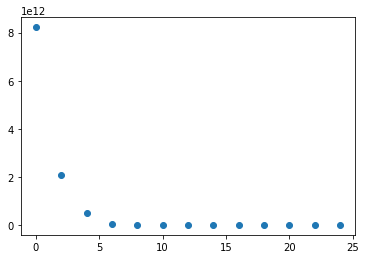

In [4]:
from PySDM.products.state import KMoments
n_sd = 2**18
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=1 * si.s, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = kernel_b)))
products = [ParticlesNumberVolumeSpectrum(), KMoments()]
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)
particles = builder.build(attributes, products)

tsteps = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
k = 2
Mk = np.zeros((len(tsteps), k))

for i, step in enumerate(tsteps):
    particles.run(step - particles.n_steps)
    Mk[i,:] = (particles.products['M0-Mk'].get(k))
    
pyplot.scatter(tsteps, Mk[:,0])
print(Mk)